In [1]:
# default_exp analyses

# Measuring the Serial Position Effect in Repetition Data
The serial position effect describes how our memory is affected by the position of information in a sequence. 
Here we extend on previous implementations to ensure recall rates are successfully measured and visualized when study lists can include two presentations of study items. 

## Function

In [2]:
from repetition_cmr.analyses import recall_by_all_study_positions

In [3]:
# export

from numba import njit
import numpy as np

@njit(nogil=True)
def spc(trials, presentations):
    
    list_length = len(presentations[0])
    result = np.zeros(list_length, dtype=np.int32)
    all_study_positions = recall_by_all_study_positions(trials, presentations) 
    
    for trial_index in range(len(trials)):
        for study_position in range(list_length):
            result[study_position] += study_position+1 in all_study_positions[:,trial_index]
    
    return result/len(trials)

In [14]:
# export

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from compmemlearn.datasets import events_metadata, generate_trial_mask


def plot_spc(data, trial_query, contrast_name='', labels=None, axis=None):

    if axis is None:
        plt.figure()
        axis = plt.gca()

    if labels is None:
        labels = [''] * len(data)

    result = []
    for data_index, events in enumerate(data):

        # generate and subset trials array and list of list_lengths based on trial_query
        trials, list_lengths, presentations = events_metadata(events)
        trial_mask = generate_trial_mask(events, trial_query)
        chose = [i for i in range(len(trial_mask)) if np.sum(trial_mask[i]) != 0]
        assert(len(chose) == 1)
        chose = chose[0]
        trials = trials[chose]
        list_length = list_lengths[chose]
        presentations = presentations[chose]
        trial_mask = trial_mask[chose]

        for subject in pd.unique(events.subject):
            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f"subject == {subject}")[chose], trial_mask
            )

            if np.sum(subject_specific_trial_mask) == 0:
                continue

            result.append(pd.DataFrame.from_dict(
                {
                    "subject": subject,
                    "input": np.arange(1, len(presentations[0]) + 1),
                    "recall": spc(trials[subject_specific_trial_mask], presentations[subject_specific_trial_mask]),
                    contrast_name: labels[data_index],
                }
            ))

    result = pd.concat(result)

    sns.lineplot(ax=axis, data=result, x='input', y='recall', err_style='bars', hue=contrast_name)
    axis.set(xlabel='Study Position', ylabel='Recall Rate')
    axis.set_xticks(np.arange(0, list_length+int(list_length/10), int(list_length/10)))
    axis.set_ylim((0, 1))

    if contrast_name:
        axis.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return axis

## Howard & Kahana (2005) Dataset
> Kahana, M. J., & Howard, M. W. (2005). Spacing and lag effects in free recall of pure lists. Psychonomic Bulletin & Review, 12(1), 159-164.

0.3174747474747475

0.33534246575342463

0.36587570621468923



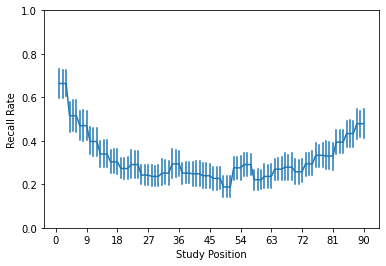

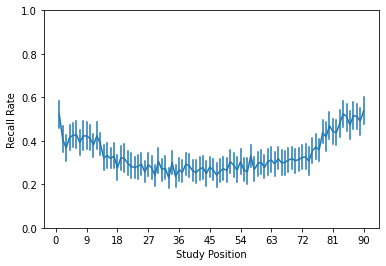

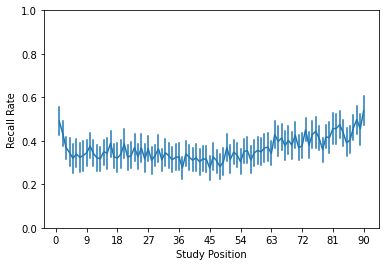

In [15]:
import pandas as pd
from compmemlearn.datasets import events_metadata, generate_trial_mask

events = pd.read_csv('../../../compmemlearn/data/HowardKahana2005.csv')
trials, list_lengths, presentations = events_metadata(events)

for condition in [0, 2, 1]:
    trial_mask = generate_trial_mask(events, f"condition == {condition}")[0]
    print(np.mean(spc(trials[0][trial_mask], presentations[0][trial_mask])))
    plot_spc([events], f"condition == {condition}", contrast_name='', labels=None, axis=None)
    print()

## Lohnas & Kahana (2014) Dataset
> Siegel, L. L., & Kahana, M. J. (2014). A retrieved context account of spacing and repetition effects in free recall. Journal of Experimental Psychology: Learning, Memory, and Cognition, 40(3), 755.

0.3544642857142857

0.5973809523809523

0.6347619047619049

0.42095238095238086



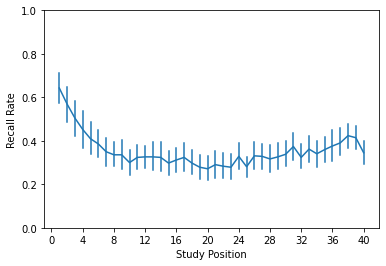

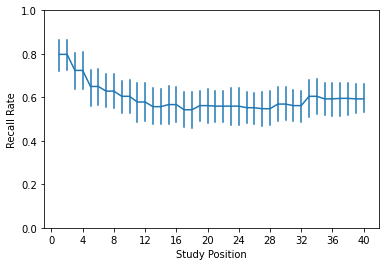

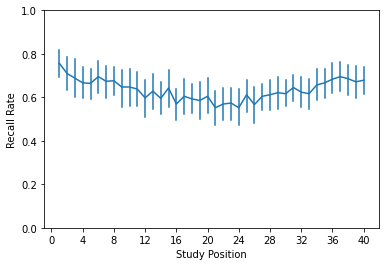

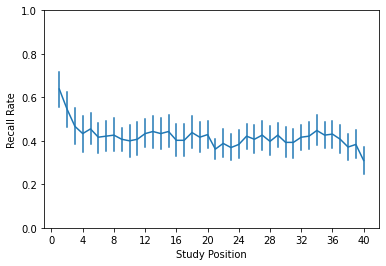

In [16]:
import pandas as pd
from compmemlearn.datasets import events_metadata, generate_trial_mask

events = pd.read_csv('../../../compmemlearn/data/LohnasKahana2014.csv')
trials, list_lengths, presentations = events_metadata(events)

for condition in [1, 2, 3, 4]:
    trial_mask = generate_trial_mask(events, f"condition == {condition}")[0]
    print(np.mean(spc(trials[0][trial_mask], presentations[0][trial_mask])))
    plot_spc([events], f"condition == {condition}", contrast_name='', labels=None, axis=None)
    print()